# Image classification

## CIFAR 10 dogs & airplanes

In [79]:
from pathlib import Path

DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'
VALID_PATH = PATH/'test'

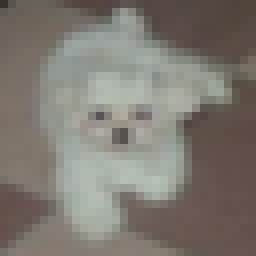

In [19]:
import PIL

dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = PIL.Image.open(dog_fn)
dog_image.resize((256,256))

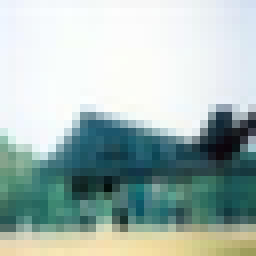

In [20]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = PIL.Image.open(air_fn)
air_image.resize((256,256))

## Previous modules

In [106]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [94]:
default_device = torch.device('cuda')

In [156]:
class Simple_CNN(nn.Module):
    def __init__(self, actns, kernel_szs, strides):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(actns[i], actns[i+1], kernel_szs[i], stride=strides[i], padding=kernel_szs[i]//2)
            for i in range(len(strides))])

    def forward(self, xb):
        for conv in self.convs: xb = F.relu(conv(xb))
        xb = F.adaptive_avg_pool2d(xb, 1)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [213]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl,self.device = dl,device
        
    def __iter__(self):
        for b in self.dl: yield [o.to(self.device) for o in b]
    
    def __len__(self): return (len(self.dl))

def get_dataloader(ds, bs, shuffle, device):
        return DeviceDataLoader(DataLoader(ds, batch_size=bs, shuffle=shuffle), device)

class DataBunch():
    def __init__(self, train, valid, bs, device=None):
        self.device = default_device if device is None else device
        self.train_dl = get_dataloader(train, bs,   shuffle=True,  device=self.device)
        self.valid_dl = get_dataloader(valid, bs*2, shuffle=False, device=self.device)

class Learner():
    loss_fn = F.nll_loss
    
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        
    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        fit(epochs, self.model, self.loss_fn, opt, data.train_dl, data.valid_dl)

In [193]:
from tqdm import tqdm, tqdm_notebook, trange, tnrange

In [232]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [239]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in tnrange(epochs):
        model.train()
        it = tqdm_notebook(train_dl)
        for xb,yb in it:
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            it.set_postfix_str(loss)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

## Simple model

In [220]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    classes.sort(key=lambda d: d.name)
    return classes

In [221]:
classes = find_classes(TRAIN_PATH)
classes

[PosixPath('data/cifar10_dog_air/train/airplane'),
 PosixPath('data/cifar10_dog_air/train/dog')]

In [222]:
def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

In [223]:
def pil2tensor(image):
    arr = np.array(image, dtype=np.float32)/255.
    if len(arr.shape)==2: arr = np.repeat(arr[...,None],3,2)
    return torch.from_numpy(arr).permute((2,0,1))

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        classes = find_classes(folder)
        images_by_class = [get_image_files(c) for c in classes]
        self.x,self.y = [],[]
        class2idx = {v.name: k for k,v in enumerate(classes)}
        for x,y in zip(images_by_class, classes):
            self.x += x
            self.y += [class2idx[y.name]] * len(x)
        
    def __len__(self): return len(self.x)

    def __getitem__(self,i):
        x = PIL.Image.open(self.x[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [224]:
train_ds = ImageFolderDataset(TRAIN_PATH)
valid_ds = ImageFolderDataset(VALID_PATH)

In [225]:
bs=64

In [226]:
data = DataBunch(train_ds, valid_ds, bs)

In [227]:
model = Simple_CNN([3,16,16,2], [3,3,3], [2,2,2])
learner = Learner(data, model)

In [230]:
epochs=2
lr=0.1

In [231]:
learner.fit(epochs, lr)

0 0.4717185142040253


1 0.7914901844263077



## Darknet

In [240]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [241]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [242]:
model = Darknet([1, 2, 4, 6, 3], num_classes=2, nf=32)

In [243]:
learner = Learner(data, model)
learner.loss_fn = F.cross_entropy

In [244]:
learner.fit(epochs, 0.01)

0 0.7915769119262696


1 1.3907445892989636


## fin